# Floquet theory based phase amplitude decomposition

In [27]:
] status

    Status `C:\Users\liaog\.julia\environments\v1.3\Project.toml`
  [6e4b80f9] BenchmarkTools v0.5.0
  [8f4d0f93] Conda v1.4.1
  [d38c429a] Contour v0.5.2
  [0c46a032] DifferentialEquations v6.13.0
  [61744808] DynamicalSystems v1.4.0
  [c87230d0] FFMPEG v0.3.0
  [f6369f11] ForwardDiff v0.10.10
  [f67ccb44] HDF5 v0.13.1
  [7073ff75] IJulia v1.21.2
  [c601a237] Interact v0.10.3
  [d3863d7c] InteractBase v0.10.3
  [d1acc4aa] IntervalArithmetic v0.16.1
  [d2bf35a9] IntervalRootFinding v0.5.2
  [4138dd39] JLD v0.9.2
  [b964fa9f] LaTeXStrings v1.1.0
  [dd61e66b] MDBM v0.1.4
  [2774e3e8] NLsolve v4.3.0
  [09606e27] ODEInterfaceDiffEq v3.6.0
  [1dea7af3] OrdinaryDiffEq v5.34.1
  [91a5bcdd] Plots v1.0.11
  [d330b81b] PyPlot v2.9.0
  [90137ffa] StaticArrays v0.12.1
  [d6d074c3] VideoIO v0.6.7
  [0f1e0344] WebIO v0.8.13
  [8ba89e20] Distributed 
  [37e2e46d] LinearAlgebra 


In [1]:
using Plots
using DifferentialEquations
using Interact

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1273
┌ Info: Precompiling DifferentialEquations [0c46a032-eb83-5123-abaf-570d42b7fbaa]
└ @ Base loading.jl:1273
┌ Info: Precompiling Interact [c601a237-2ae4-5e1e-952c-7a85b0c7eef1]
└ @ Base loading.jl:1273


HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-10835430197814369462\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-13926044293941239123\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-10835430197814369462\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

## Shooting limit cycle and fundamental matrix solution of variational equation

In [2]:
using LinearAlgebra

function shooting_ode(myode,T0,x0,pars,dim)
# myode: the ode combined with Jacobian
# T0: initial guess of period.  x0: initial guess of solution and fundamental solution
# p: prameters.    dim: the dimension of the original ODE.
    d_xt = ones(dim,1)
    count = 0;
    sol = []
    M_can = []
    while (norm(d_xt)>1e-3) & (count<=100)
        tspan = (0.,T0)
        funda_x = Matrix(1.0I, dim, dim)
        fx = funda_x[1:end]
        u0 = [x0;fx]
        prob = ODEProblem(myode,u0,tspan,pars)
        sol = solve(prob,Rosenbrock23())
#         sol = solve(prob,Rodas5())
        # Make up the recurrence matrix
        M_can = sol[(dim+1:end),end]
        M_can = reshape(M_can,(dim,dim))'
        
        temp = myode(ones(dim*(dim+1),1),u0,pars,0)
        F_tran = temp[1:dim]
        A = [M_can-Matrix(1.0I, dim, dim) F_tran;
            F_tran' 0]
        B = [x0-sol[(1:dim),end];0]
        d_xt = A\B
        x0 = x0 + d_xt[1:dim]
        T0 = T0 + d_xt[end]
        count = count + 1;
#         println(count)
#         println(d_xt)
#         println(x0)
#         println(sol[1])
    end
    return sol,Matrix(M_can)
end

shooting_ode (generic function with 1 method)

### test the method with different systems

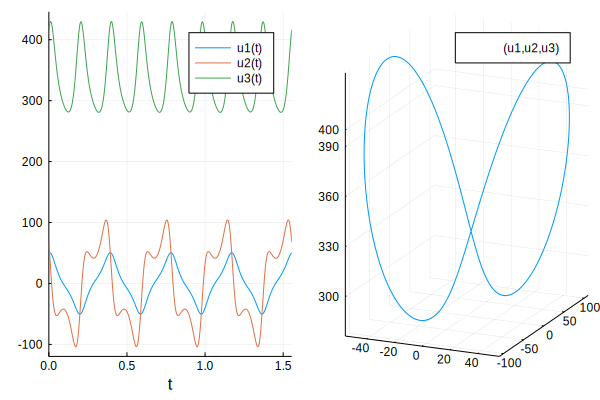

In [105]:
function ode_lorenz(du,u,p,t)
    x,y,z,x11,x12,x13,x21,x22,x23,x31,x32,x33 = u
    σ,ρ,β = p
    du[1] = σ*(y-x)
    du[2] = x*(ρ-z) - y
    du[3] = x*y - β*z
    Jac = [-σ σ 0;
            ρ-z -1 -x;
            y x -β]
    M = [x11 x12 x13;x21 x22 x23;x31 x32 x33]
    Jac_rhs = Jac*M
    du[4:12] = Jac_rhs'[1:end]
    du
end

pars = [10.,350.,8/3]
# pars = [10.,28.,8/3]

# test for lorenz system (3D)
x0 = [-49.825555786235014; -31.729050390630018; 428.7738369520949]
# x0 = [20.1;20.1;20.1]
T0 = 1
sol_lorenz,M = shooting_ode(ode_lorenz,T0,x0,pars,3);

fig1 = plot(sol_lorenz,vars=[1,2,3])
fig2 = plot(sol_lorenz,vars=(1,2,3))
plot(fig1,fig2,layout=(1,2))
# eigvals(M)

# worked

# u0 = [-49.825555786235014; -31.729050390630018; 428.7738369520949 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0]
# tspan = (0,10.)

# prob = ODEProblem(ode_rossler,u0,tspan,pars)
# sol = solve(prob,Rodas5())
# plot(sol,vars=(1,2))
# plot(sol,vars=(0,1))

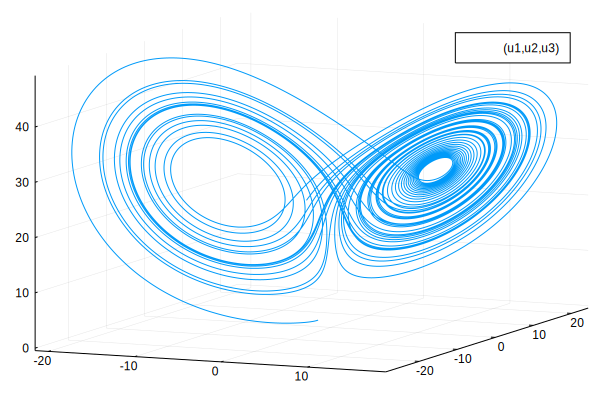

In [168]:
u0 = [-1, -1, 1, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0]
tspan = (0,40.)
pars = [10.,28.,8/3]

prob = ODEProblem(ode_lorenz,u0,tspan,pars)
sol = solve(prob,Rosenbrock23())

using PyPlot
# plotlyjs()
ion()
plot(sol,vars=(1,2,3))

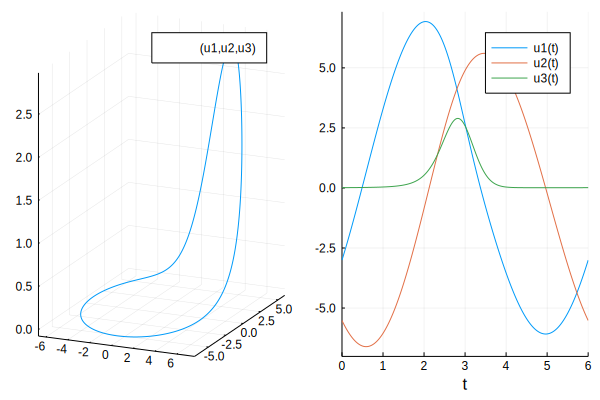

In [140]:
function ode_rossler(du,u,p,t)
    x,y,z,x11,x12,x13,x21,x22,x23,x31,x32,x33 = u
    a,b,c = p
    du[1] = -y-z
    du[2] = x+a*y
    du[3] = b+z*(x-c)
    Jac = [0 -1 -1;
            1 a 0;
            z 0 x-c]
    M = [x11 x12 x13;x21 x22 x23;x31 x32 x33]
    Jac_rhs = Jac*M
    du[4:12] = Jac_rhs'[1:end]
    du    
end

pars = [0.1,0.1,4]


x0 = [-2.;-6.;0.]  # Initial guess must be appropariate
T0 = 7.1
sol_rossler,M = shooting_ode(ode_rossler,T0,x0,pars,3);

# worked

# u0 = [-6.0, 2.7, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0]
# tspan = (0,100.)

# prob = ODEProblem(ode_rossler,u0,tspan,pars)
# sol = solve(prob,Rodas5())
# plot(sol,vars=(1,2))
# plot(sol,vars=(0,1))

fig1 = plot(sol_rossler,vars=(1,2,3))
fig2 = plot(sol_rossler,vars=[1,2,3])
plot(fig1,fig2,layout=(1,2))
# eigvals(M)

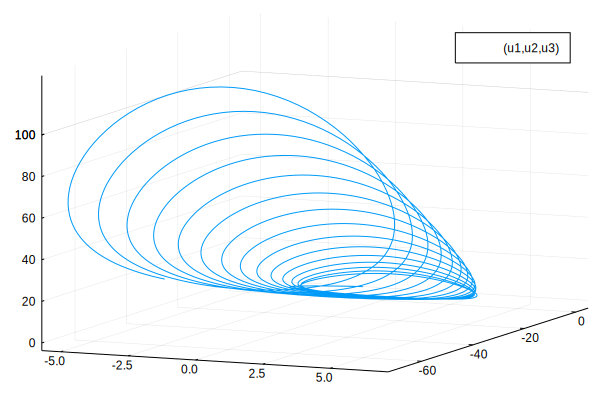

In [138]:
function ode_rossler!(du,u,p,t)
    x,y,z = u
    a,b,c = p
    du[1] = -y-z
    du[2] = x+a*y
    du[3] = b+z*(x-c)  
end

u0 = [-1.0, 2.7, 1.0]
pars = [1//5,1//5,0.5]
tspan = (0,30.)

prob = ODEProblem(ode_rossler!,u0,tspan,pars)
sol = solve(prob,Rosenbrock23())
plot(sol,vars=(1,2,3))

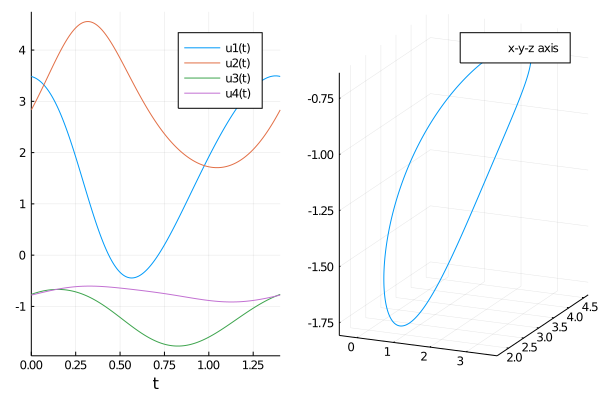

In [31]:
# Worked well
function ode_4Dtest(du,u,p,t)
    x,y,z,w,x11,x12,x13,x14,x21,x22,x23,x24,x31,x32,x33,x34,x41,x42,x43,x44 = u
    a = p
    du[1] = -x + 2*a - y^2 + (z^2+w^2)/2
    du[2] = -y + (x*y-z*w) + (w^2-z^2)/2
    du[3] = -z + (y-x)*(z+w)/2
    du[4] = -w + (y+x)*(z-w)/2
    Jac = [-1 -2*y z w;
            y -1+x -w-z -z+w;
            -(z+w)/2 (z+w)/2 -1+(y-x)/2 (y-x)/2;
            (z-w)/2 (z-w)/2 (y+x)/2 -1-(y+x)/2]
    M = [x11 x12 x13 x14;
        x21 x22 x23 x24;
        x31 x32 x33 x34;
        x41 x42 x43 x44]
    Jac_rhs = Jac*M
    du[5:20] = Jac_rhs'[1:end]
    du    
end

#------------------------------------------------------
x0 = [3.4;2.8;-0.66;-0.66]
T0 = 1.3
pars = 5

sol_4Dtest,M = shooting_ode(ode_4Dtest,T0,x0,pars,4);

fig1 = plot(sol_4Dtest,vars=[1,2,3,4])
fig2 = plot(sol_4Dtest,vars=(1,2,3),label="x-y-z axis")
plot(fig1,fig2)
# eigvals(M)

#------------------------------------------------------
# funda_x = Matrix(1.0I, 4, 4)
# fx = funda_x[1:end]
# u0 = [.2;.2;.2;.2;fx]
# tspan = (0,100.)
# pars = 5
# prob = ODEProblem(ode_4Dtest,u0,tspan,pars)
# sol = solve(prob,Rosenbrock23())
# # plot(sol[end-50:end],vars=(1,2,3),camera=(45,45))
# plot(sol(50:.01:55,idxs=[1,2,3,4]))

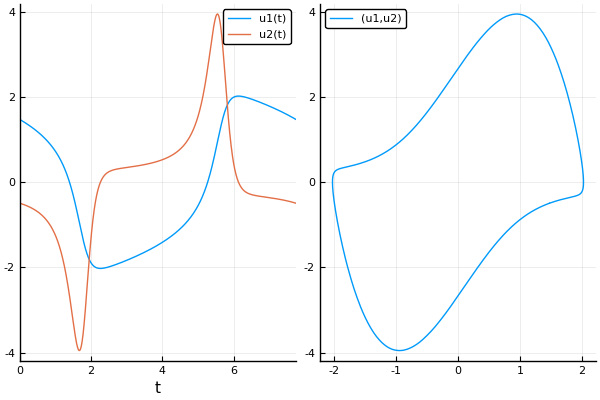

In [86]:
# Worked well
# Combined Van der pol oscillator with jacabian
function ode_VDP(du,u,p,t)
    x,y,x11,x12,x21,x22 = u
    μ = p
    du[1] = y
    du[2] = μ*(1-x^2)*y - x
    Jac = [0 1;
        -2*μ*x*y-1 μ*(1-x^2)]
    M = [x11 x12;
         x21 x22]
    Jac_rhs = Jac*M
    du[3:6] = Jac_rhs'[1:end]     # du[3]:x11, du[4]:x12, du[5]:x21, du[6]:x22
    du
end

# x0 = [1;4]
x0 = [1.4714104452921224;-0.4932062692360556]
sol_VDP,M = shooting_ode(ode_VDP,8.,x0,2.1,2);

fig1 = plot(sol_VDP,vars=[1,2])
fig2 = plot(sol_VDP,vars=(1,2))
plot(fig1,fig2)

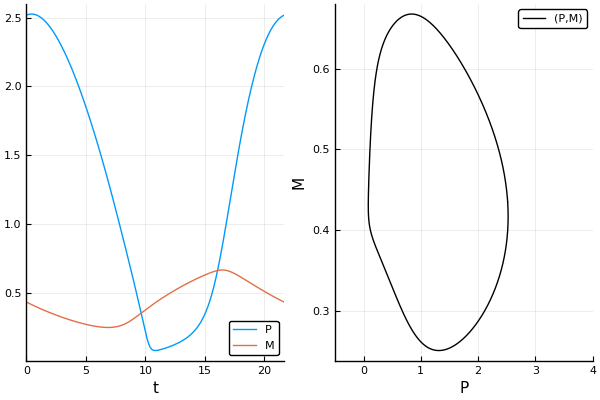

In [21]:
# The Novak Tyson oscillator
# For DD: kD = 0.05, For LL: kD = 0.1
function ode_NT(du,u,p,t)
    P,M,x11,x12,x21,x22 = u
    Φ,kf,kD,ϵ = p
    
    du[1] = Φ*(M - kD*P - kf*P/(0.1+P+2*P^2))
    du[2] = Φ*ϵ*(-M + 1/(1+P^4))
    
    Jac = [Φ*(-kD+kf*(-0.1+2*P^2)/(0.1+P+2*P^2)^2) Φ;
        -4*Φ*ϵ*P^3/(1+P^4)^2 -Φ*ϵ]
    M = [x11 x12;
         x21 x22]
    Jac_rhs = Jac*M
    du[3:6] = Jac_rhs'[1:end]     # du[3]:x11, du[4]:x12, du[5]:x21, du[6]:x22
    du
end

# x0 = [1;4]
# x0 = [3.1;0.2]
x0 = [3.77;0.3]
# pars = [2.1,1.,0.05,0.05]
pars = [2.1,1.,0.1,0.05]
sol_NT,M = shooting_ode(ode_NT,26.,x0,pars,2);

pyplot()
fig1 = plot(sol_NT,vars=[1,2],labels=["P" "M"])
fig2 = plot(sol_NT,vars=(1,2),label="(P,M)",c=:black,xlims=(-0.5,4),xlabel="P",ylabel="M")
figf = plot(fig1,fig2)
# savefig(figf, "C:\\Users\\liaog\\Documents\\Julia_codes\\figures\\Parameterization\\NT_LC_20200602.png")

In [22]:
using LinearAlgebra
# sol.t[end]
# sol[1]
T = sol_NT.t[end]
eigvals(M)
# println(log.(eigvals(M))/T)
# sol_VDP
B = real(log(M)/T)
# real(exp(1.1*B))
tem = eigen(B)     # The columns are eigenvectors
# M
# real(B)
# diagm(eigvals(B))
# B*tem.vectors[:,1] - tem.values[1]*tem.vectors[:,1]
# T
# sol_NT
# exp(28*(1.1))


Eigen{Float64,Float64,Array{Float64,2},Array{Float64,1}}
eigenvalues:
2-element Array{Float64,1}:
 -0.5370610970759803  
 -8.546104336691618e-5
eigenvectors:
2×2 Array{Float64,2}:
 -0.997727    0.67901 
  0.0673877  -0.734129

## Computing Floquet normal form

In [23]:
T = sol_NT.t[end]
B = real(log(M)/T)
# eigvals(B)

# Matrix exponential
# fexp(t) = real(exp(t*B))

# Fundamental matrix solution
function sol_funda(t,sol,dim)
    temp = sol(t)
    M_can = temp[dim+1:end]
    M_can = reshape(M_can,(dim,dim))'
    return Matrix(M_can)
end

# The periodic matrix function
PP(t) = sol_funda(t,sol_NT,2)*inv(exp(t*B))

PP (generic function with 1 method)

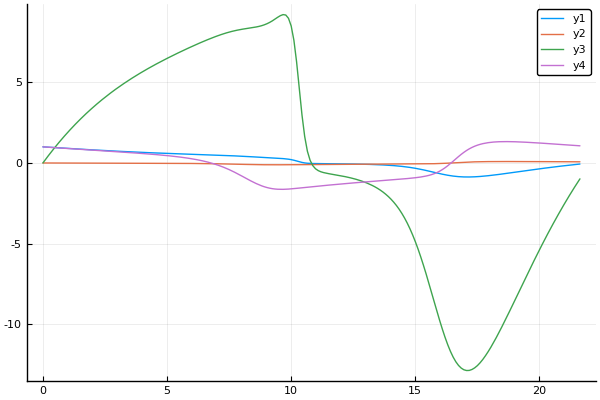

In [24]:
mysol = sol_NT
T = sol_NT.t[end]
# mysol = sol_VDP
# T = sol_VDP.t[end]
# plot(0:0.05:T,t->PP(t)[1])
# plot!(0:0.05:T,t->PP(t)[2])
# plot!(0:0.05:T,t->PP(t)[3])
# plot!(0:0.05:T,t->PP(t)[4])
# PP(0.3)
# PP(0.3)[1]
trange = range(0,stop=T,length=200)
fig1 = plot(trange,t->sol_funda(t,mysol,2)[1])
plot!(trange,t->sol_funda(t,mysol,2)[2])
plot!(trange,t->sol_funda(t,mysol,2)[3])
plot!(trange,t->sol_funda(t,mysol,2)[4])
# sol_funda(5.,mysol,2)
# savefig(fig1, "C:\\Users\\liaog\\Documents\\Julia_codes\\figures\\Parameterization\\NT_funda_20200602.png")

## Derive the parameterization

In [25]:
function Parametriz(θ,σ,sol,M,dim)

# The dimension of σ must be the same the dimension of stable eigendirection
# M: monodromy matrix
    
    gamma_t = sol(θ)[1:dim]
    PP_θ = sol(θ)[dim+1:end]
    PP_θ = Matrix(reshape(PP_θ,(dim,dim))')
    
    T = sol.t[end]
    
    B = real(log(M)/T)
    evalues = eigvals(B)
    evectors = eigvecs(B)
    
    x = gamma_t
    # sum up the stable direction.
    count = 1
    for i = 1:length(evalues)
        if(evalues[i]<0) && (abs(evalues[i])>1e-2)
            x = x + PP_θ*exp(-θ*evalues[i])*evectors[:,i]*σ[count]
            count += 1
        end
    end
    
    # Multiply by matrix exponential
#     PP_θ = PP_θ*inv(exp(θ*B))
    
#     x = gamma_t + PP_θ*evectors*σ
    
    return x
end

Parametriz (generic function with 1 method)

### isostable

In [17]:
# Parametriz(0,[1;-1],sol_VDP,2)
mysol = sol_NT

Parametriz(1,[0;0],mysol,M,2)
# sol_VDP.t
tspan = 0:0.05:T

@manipulate for σ = 0:0.01:0.1
    gammatest = map(t->Parametriz(t,0,mysol,M,2),tspan)
    plot(first.(gammatest),last.(gammatest))
    gammatest = map(t->Parametriz(t,σ,mysol,M,2),tspan)
    plot!(first.(gammatest),last.(gammatest))
end

# gammatest = map(t->Parametriz(t,[0;0],sol_VDP,2),tspan)
# plot(first.(gammatest),last.(gammatest))

MethodError: MethodError: no method matching Parametriz(::Int64, ::Array{Int64,1}, ::ODESolution{Float64,2,Array{Array{Float64,1},1},Nothing,Nothing,Array{Float64,1},Array{Array{Array{Float64,1},1},1},ODEProblem{Array{Float64,1},Tuple{Float64,Float64},true,Array{Float64,1},ODEFunction{true,typeof(ode_NT),UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing},Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},DiffEqBase.StandardODEProblem},Rosenbrock23{0,true,DefaultLinSolve,DataType},OrdinaryDiffEq.InterpolationData{ODEFunction{true,typeof(ode_NT),UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing},Array{Array{Float64,1},1},Array{Float64,1},Array{Array{Array{Float64,1},1},1},OrdinaryDiffEq.Rosenbrock23Cache{Array{Float64,1},Array{Float64,1},Array{Float64,1},Array{Float64,2},Array{Float64,2},OrdinaryDiffEq.Rosenbrock23Tableau{Float64},DiffEqBase.TimeGradientWrapper{ODEFunction{true,typeof(ode_NT),UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing},Array{Float64,1},Array{Float64,1}},DiffEqBase.UJacobianWrapper{ODEFunction{true,typeof(ode_NT),UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing},Float64,Array{Float64,1}},DefaultLinSolve,SparseDiffTools.ForwardColorJacCache{Array{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.UJacobianWrapper{ODEFunction{true,typeof(ode_NT),UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing},Float64,Array{Float64,1}},Float64},Float64,6},1},Array{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.UJacobianWrapper{ODEFunction{true,typeof(ode_NT),UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing},Float64,Array{Float64,1}},Float64},Float64,6},1},Array{Float64,1},Array{Array{NTuple{6,Bool},1},1},UnitRange{Int64},Nothing},ForwardDiff.DerivativeConfig{ForwardDiff.Tag{DiffEqBase.TimeGradientWrapper{ODEFunction{true,typeof(ode_NT),UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing},Array{Float64,1},Array{Float64,1}},Float64},Array{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.TimeGradientWrapper{ODEFunction{true,typeof(ode_NT),UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing},Array{Float64,1},Array{Float64,1}},Float64},Float64,1},1}}}},DiffEqBase.DEStats}, ::Int64)
Closest candidates are:
  Parametriz(::Any, ::Any, ::Any, ::Any, !Matched::Any) at In[16]:6

### isochron

In [26]:
σspan = -0.05:0.01:0.05
# θ = 0
@manipulate for θ = 0:0.1:T
#     gammatest = map(t->Parametriz(θ,[0;t],sol_VDP,2),σspan)
    gammatest = map(t->Parametriz(θ,t,mysol,M,2),σspan)
    plot(mysol,vars = (1,2))
    plot!(first.(gammatest),last.(gammatest))
end

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["θ"], Dict{Symbol,Any}(:className => "interact ",:style => Dict{Any,Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol,Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol,Any}(:max => 217,:min => 1,:attributes => Dict{Any,Any}(:type => "range",Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}","orient" => "horizontal"),:step => 1,:className => "slider slider is-fullwidth",:style => Dict{Any,Any}()))], Dict{Symbol,Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol,Any}(:className => "interact-flex-row-right"))], Dict{Symbol,Any}(:className => "interact-flex-row interact-widget")), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing),"index" => (Observable{Any} with 2 listeners. Value:
109, nothing)), Set(String[]), nothing, Asset[Asset("js", "knockout", "C:\\Users\\liaog\\.julia\\packages\\Knockout\\IP1uR\\src\\..\\assets\\knockout.js"), Asset("js", "knockout_punches", "C:\\Users\\liaog\\.julia\\packages\\Knockout\\IP1uR\\src\\..\\assets\\knockout_punches.js"), Asset("js", nothing, "C:\\Users\\liaog\\.julia\\packages\\InteractBase\\9mFwe\\src\\..\\assets\\all.js"), Asset("css", nothing, "C:\\Users\\liaog\\.julia\\packages\\InteractBase\\9mFwe\\src\\..\\assets\\style.css"), Asset("css", nothing, "C:\\Users\\liaog\\.julia\\packages\\Interact\\SbgIk\\src\\..\\assets\\bulma_confined.min.css")], Dict{Any,Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")],"index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(sz_max:32,sz_curr:0), Set(AbstractConnection[]), Base.GenericCondition{Base.AlwaysLockedST}(Base.InvasiveLinkedList{Task}(Task (runnable) @0x000000003f9899f0, Task (runnable) @0x000000003f9899f0), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"0.0\",\"0.1\",\"0.2\",\"0.3\",\"0.4\",\"0.5\",\"0.6\",\"0.7\",\"0.8\",\"0.9\",\"1.0\",\"1.1\",\"1.2\",\"1.3\",\"1.4\",\"1.5\",\"1.6\",\"1.7\",\"1.8\",\"1.9\",\"2.0\",\"2.1\",\"2.2\",\"2.

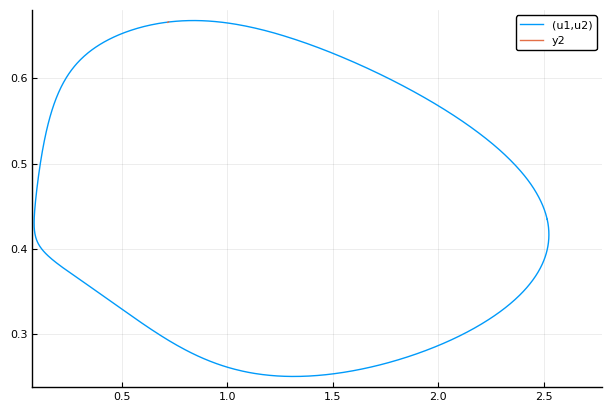

isochrones (generic function with 1 method)

In [27]:
function isochrones(ode,sol,M,dim)
# % plot isochrons of a planar dynamical system x’=F(t,x)
# % at points given by the vector ’phases’.
# % ’x0’ is a point on the limit cycle (2x1-vector)
# % v0 is the linear bundles
# % T= phases(end); % is the period of the cycle
    T = sol.t[end]
    tau = T/500; # time step of integration
    phases = 0:2:T
    m = 200; # spatial grid
    k = 2; # the number of skipped cycles
    
    lc = sol[1:2,:]
    lc_max = findmax(lc,dims=2)[1]
    lc_min = findmin(lc,dims=2)[1]
    dx = (lc_max - lc_min)/m; # spatial resolution

    center = (lc_max + lc_min)/2; # center of the limit cycle

#     %------------------------My part
    σ = 0.1
    θ = 0
#   σ = 0.5;     % for morris_lecar
#   Approximate the initial segment with the parameterization.
    iso = [Parametriz(θ,-σ,sol,M,dim) Parametriz(θ,σ,sol,M,dim)]
    
#     myiso = cell([1 length(phases)]);
    myiso = Array{Any,1}(undef, length(phases))

#     % if any(iso(:,1)<0)
#     %     iso(:,1)=x0;
#     % end
#     % iso=[x0+.1*m^0.5*dx, x0+m^0.5*dx]; % isochron’s initial segment
#     %--------------------------------------

    for t = 0:-tau:-(k+1)*T # backward integration
        for i = 1:length(iso[1,:])
            F_right = ode(ones(dim*(dim+1),1),[iso[:,i];ones(dim*dim,1)],pars,t)  # right hand side of the extended system
            F = F_right[1:dim]
            iso[:,i] = iso[:,i] - tau*F
        end   
        i = 1;
        while i<=length(iso[1,:]) # remove infinite solutions
            if any(abs.(iso[:,i]-center).>1.5*m*dx) # check boundaries
                iso = [iso[:,1:i-1] iso[:,i+1:end]]; # remove
    #----------------- NT oscillator should rool out some negative value-------------------------
            elseif any(iso[:,i].<-0.13)
                iso = [iso[:,1:i-1] iso[:,i+1:end]]; # remove
    #----------------------------------------------------------------------------------------------------------------
            else
                i = i+1;
            end
        end
        i = 1;
        while i < length(iso[1,:])
            d = sqrt(sum(((iso[:,i]-iso[:,i+1])/dx).^2)); # normalized distance
            if (d > 2) # add a point in the middle
                iso = [iso[:,1:i] (iso[:,i]+iso[:,i+1])/2 iso[:,i+1:end]];
    #         end
    #         if d < 0.5 % remove the point
    #             iso = [iso(:,1:i), iso(:,i+2:end)];
            else
                i=i+1;
            end
        end
        mymin = findmin(abs.(phases .- mod(-t,T)));

        if mymin[1] < tau/2 # plot the isochrons if t is close to one of the phase points.
#           plot(iso(1,:),iso(2,:),c=:red,lw=1); drawnow;
            myiso[mymin[2]] = iso;
        end
#     println(iso)
    end
    return myiso
end

In [28]:
myiso = isochrones(ode_NT,sol_NT,M,2);

In [338]:
@manipulate for i = 1:length(myiso)
    plot(sol_NT,vars=(1,2),lw=2,xlims=(0,5),ylims=(0,0.8),c=:black)
    plot!(myiso[i][1,:],myiso[i][2,:],lw=2)
end
# myiso[1]

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["i"], Dict{Symbol,Any}(:className => "interact ",:style => Dict{Any,Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol,Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol,Any}(:max => 29,:min => 1,:attributes => Dict{Any,Any}(:type => "range",Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}","orient" => "horizontal"),:step => 1,:className => "slider slider is-fullwidth",:style => Dict{Any,Any}()))], Dict{Symbol,Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol,Any}(:className => "interact-flex-row-right"))], Dict{Symbol,Any}(:className => "interact-flex-row interact-widget")), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing),"index" => (Observable{Int64} with 2 listeners. Value:
15, nothing)), Set(String[]), nothing, Asset[Asset("js", "knockout", "C:\\Users\\liaog\\.julia\\packages\\Knockout\\IP1uR\\src\\..\\assets\\knockout.js"), Asset("js", "knockout_punches", "C:\\Users\\liaog\\.julia\\packages\\Knockout\\IP1uR\\src\\..\\assets\\knockout_punches.js"), Asset("js", nothing, "C:\\Users\\liaog\\.julia\\packages\\InteractBase\\9mFwe\\src\\..\\assets\\all.js"), Asset("css", nothing, "C:\\Users\\liaog\\.julia\\packages\\InteractBase\\9mFwe\\src\\..\\assets\\style.css"), Asset("css", nothing, "C:\\Users\\liaog\\.julia\\packages\\Interact\\SbgIk\\src\\..\\assets\\bulma_confined.min.css")], Dict{Any,Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")],"index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(sz_max:32,sz_curr:0), Set(AbstractConnection[]), Base.GenericCondition{Base.AlwaysLockedST}(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00000000130bc5d0, Task (runnable) @0x00000000130bc5d0), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"1\",\"2\",\"3\",\"4\",\"5\",\"6\",\"7\",\"8\",\"9\",\"10\",\"11\",\"12\",\"13\",\"14\",\"15\",\"16\",\"17\",\"18\",\"19\",\"20\",\"21\",\"22\",\"23\",\"24\",\"25\",\"26\",\"27\",\"28\",\

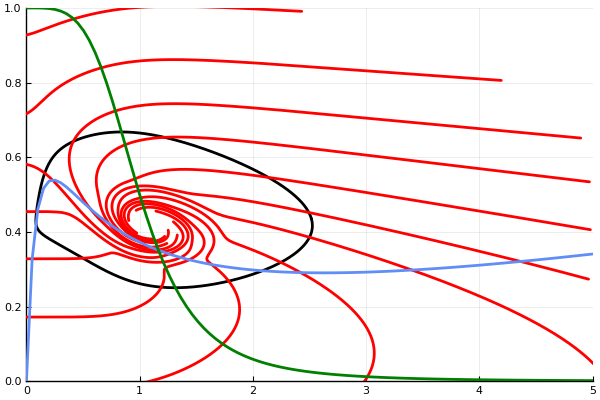

In [29]:
pyplot()
# fig = plot(sol_NT,vars=(1,2),lw=2,xlims=(0.8,1.8),ylims=(0.2,0.5),legend=:false,color=:black)
# for i = 1:length(myiso)
#     plot!(fig,myiso[i][1,:],myiso[i][2,:],lw=2)
# end
# fig

fig1 = plot(sol_NT,vars=(1,2),lw=2,xlims=(0,5),ylims=(0,1),legend=:false,color=:black)
for i = 1:length(myiso)
    plot!(fig1,myiso[i][1,:],myiso[i][2,:],lw=2,c=:red)
end

# Add nullcline
φ = 2.1
kD = 0.05
eps = 0.05
kf = 1

P = range(0,stop=5,length=100)
M = range(0,stop=1,length=100)

h(x) = @. x/(0.1+x+2*x^2)
g(x) = @. 1.0/(1.0+x^4)


plot!(fig1,P,kD*P .+ kf*h(P),linewidth=2,label="P-nullcline")
plot!(fig1,P,g(P),linewidth=2,label="M-nullcline",c=:green)
# savefig(fig1, "C:\\Users\\liaog\\Documents\\Julia_codes\\figures\\Parameterization\\isochrones_NT_20200602.png")

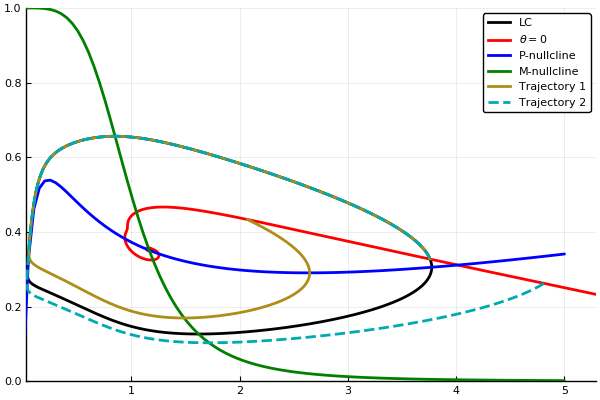

In [124]:
using LaTeXStrings
pyplot()
fig2 = plot(sol_NT,vars=(1,2),lw=2,xlims=(0,5),ylims=(0,1),color=:black,label="LC")
plot!(fig2,myiso[1][1,:],myiso[1][2,:],lw=2,c=:red,label=latexstring("\\theta=0"))

# Add nullcline
φ = 2.1
kD = 0.05
eps = 0.05
kf = 1

P = range(0,stop=5,length=100)
M = range(0,stop=1,length=100)

h(x) = @. x/(0.1+x+2*x^2)
g(x) = @. 1.0/(1.0+x^4)


plot!(fig2,P,kD*P .+ kf*h(P),lw=2,label="P-nullcline",c=:blue)
plot!(fig2,P,g(P),lw=2,label="M-nullcline",c=:green)

# Add two trajectories
tspan = (0.,T)
pars = [2.1,1.,0.05,0.05]

u0 = [myiso[1][:,200];1;0;0;1]
prob = ODEProblem(ode_NT,u0,tspan,pars)
sol = solve(prob,Rosenbrock23())
plot!(fig2,sol,vars=(1,2),lw=2,label="Trajectory 1")

u0 = [myiso[1][:,100];1;0;0;1]
prob = ODEProblem(ode_NT,u0,tspan,pars)
sol = solve(prob,Rosenbrock23())
plot!(fig2,sol,vars=(1,2),lw=2,linestyle = :dash,label="Trajectory 2")

# savefig(fig2, "C:\\Users\\liaog\\Documents\\Julia_codes\\figures\\Parameterization\\isochron_single_NT_20200602.png")

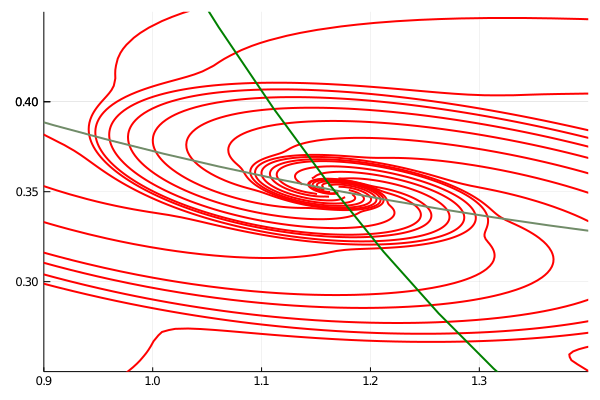

In [9]:
fig3 = plot(sol_NT,vars=(1,2),lw=2,xlims=(0.9,1.4),ylims=(0.25,0.45),legend=:false,color=:black)
for i = 1:length(myiso)
    plot!(fig3,myiso[i][1,:],myiso[i][2,:],lw=2,c=:red)
end

# Add nullcline
φ = 2.1
kD = 0.05
eps = 0.05
kf = 1

P = range(0,stop=5,length=100)
M = range(0,stop=1,length=100)

h(x) = @. x/(0.1+x+2*x^2)
g(x) = @. 1.0/(1.0+x^4)


plot!(fig3,P,kD*P .+ kf*h(P),linewidth=2,label="P-nullcline")
plot!(fig3,P,g(P),linewidth=2,label="M-nullcline",c=:green)

# savefig(fig3, "C:\\Users\\liaog\\Documents\\Julia_codes\\figures\\Parameterization\\isochrones_zoomin_NT_20200602.png")